# All imports

In [13]:
import os,sys,string, time
print (sys.version)
import ROOT
import seaborn as sns
from matplotlib.lines import Line2D
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import math
import matplotlib.pyplot as plt
import awkward 
import plotly.express as px
import numpy as np
import matplotlib.ticker as tck
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show    
import uproot3
import matplotlib.cm as cm
import matplotlib.mlab as mlab

import pandas as pd

from root_pandas import read_root
from platform import python_version

import scipy as sci
from scipy import stats
import scipy.optimize as opt

3.9.2 (default, Mar  7 2021, 07:53:23) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)]


# Loading in the Data, MC and EXT file 

In [14]:
#MC
loc_file = '/uboone/data/users/davidc/searchingfornues/v08_00_00_48/0928/run1/nslice/prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run1_reco2_reco2.root'

#Data
data_file = '/uboone/data/users/davidc/searchingfornues/v08_00_00_41/cc0pinp/0617/nslice/data_bnb_peleeFilter_uboone_v08_00_00_41_pot_run3_G1_neutrinoselection_filt.root'

#EXT
EXT_file =   '/uboone/data/users/davidc/searchingfornues/v08_00_00_43/0702/run3/numupresel/data_extbnb_mcc9.1_v08_00_00_25_reco2_G_all_reco2.root'

MC_tree = uproot3.open(loc_file)['nuselection/NeutrinoSelectionFilter']
data_tree = uproot3.open(data_file)['nuselection/NeutrinoSelectionFilter']
EXT_tree = uproot3.open(EXT_file)['nuselection/NeutrinoSelectionFilter']

#print("Here you can see all the variables available to us. We will not need most of these, but it may be beneficial to understand what the relevant ones represent")

# Choosing variables and converting to dataframe

In [15]:
variable_MC = ['topological_score','crtveto', 'nslice','slnunhits', 'slnhits','trk_llr_pid_score_v', 'weightTune','weightSplineTimesTune','category','trk_sce_end_z_v','trk_sce_end_y_v','trk_sce_end_x_v','trk_distance_v','trk_len_v','trk_score_v','trk_sce_start_z_v','trk_sce_start_y_v','trk_sce_start_x_v','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z','topological_score']
variable_data_EXT = ['topological_score','crtveto', 'crthitpe','nslice','trk_sce_end_z_v','trk_sce_end_y_v','trk_sce_end_x_v','trk_distance_v','trk_len_v','trk_score_v','trk_llr_pid_score_v','trk_sce_start_z_v','trk_sce_start_y_v','trk_sce_start_x_v','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z','crtveto','nslice', 'trk_llr_pid_score_v']

MC_frame = MC_tree.pandas.df(variable_MC, flatten=False)
data_frame = data_tree.pandas.df(variable_data_EXT, flatten=False)
EXT_frame = EXT_tree.pandas.df(variable_data_EXT, flatten=False)

# Adding back cosmics and fixing scaling

In [16]:
MC_frame.loc[(MC_frame['category']!=1)&(MC_frame['category']!=10)&(MC_frame['category']!=11)&(MC_frame['category']!=111)&(MC_frame['slnunhits']/MC_frame['slnhits']<0.2), 'category'] = 4
EXT_frame['category'] =  7
EXT_frame['scaling'] = 3.88
EXT_frame['weightSplineTimesTune'] = 1
MC_frame['scaling'] = 6.291

# Joining EXT and MC

In [17]:
df_MC = MC_frame.reset_index(drop=True)
df_EXT = EXT_frame.reset_index(drop=True)
parser = pd.io.parsers.base_parser.ParserBase({'usecols': None})
MC_EXT = pd.concat([df.set_axis(parser._maybe_dedup_names(df.columns), axis=1) for df in [df_MC, df_EXT]], ignore_index=True)

# Flattening dataframes

In [18]:
MC_EXT = MC_EXT.apply(lambda x: x.explode() if x.name in ['trk_sce_end_z_v','trk_sce_end_y_v','trk_sce_end_x_v','trk_distance_v','trk_len_v','trk_score_v','trk_llr_pid_score_v','trk_sce_start_z_v','trk_sce_start_y_v','trk_sce_start_x_v','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z','topological_score'] else x).reset_index()
MC_EXT = MC_EXT.loc[:,~MC_EXT.columns.duplicated()]
MC_EXT = MC_EXT.loc[:,~MC_EXT.columns.duplicated()]

# Weightune

In [19]:
MC_EXT['weightMC_EXTC8'] = 1.0
MC_EXT.loc[ MC_EXT['weightTune'] <= 0, 'weightTune' ] = 1.
MC_EXT.loc[ MC_EXT['weightTune'] == np.inf, 'weightTune' ] = 1.
MC_EXT.loc[ MC_EXT['weightTune'] > 100, 'weightTune' ] = 1.
MC_EXT.loc[ np.isnan(MC_EXT['weightTune']) == True, 'weightTune' ] = 1.
MC_EXT.loc[ MC_EXT['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
MC_EXT.loc[ MC_EXT['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
MC_EXT.loc[ MC_EXT['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
MC_EXT.loc[ np.isnan(MC_EXT['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

# Here you can display the data frame

# Use this function to make cuts on the variables and plot the distribution

In [20]:
#Example code for selecting variables
#Example cut
trk_len = MC_EXT['trk_len_v']

selection = (trk_len>0) & (trk_len < 30)



MC_EXT = MC_EXT[selection]




In [21]:
MC_frame

,topological_score,crtveto,nslice,slnunhits,slnhits,trk_llr_pid_score_v,weightTune,weightSplineTimesTune,category,trk_sce_end_z_v,...,trk_len_v,trk_score_v,trk_sce_start_z_v,trk_sce_start_y_v,trk_sce_start_x_v,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,topological_score,scaling
entry,,,,,,,,,,,,,,,,,,,,,
0,0.563141,0,1,987,1050,"[0.95081425, -0.7325396, 0.0404409]",1.225192,1.224627,2,"[890.6556, 903.36926, 850.8536]",...,"[121.25998, 62.083, 1.035088]","[0.9994736, 0.9554535, 0.31676278]","[850.40735, 850.2903, 850.92645]","[-3.8722866, -2.3939276, -2.3777194]","[245.80368, 246.0049, 245.51324]",245.823135,-3.698386,850.602417,0.563141,6.291
1,0.891081,0,1,1467,2285,"[0.9723389, 0.796861, -0.7361738, 0.6268964, 0...",1.000000,1.000000,2,"[331.67685, 173.68651, 150.23724, 8.620833, 92...",...,"[180.64252, 75.09592, 19.174286, 16.588932, 11...","[0.99999976, 0.9863499, 0.9319424, 0.9691491, ...","[168.67154, 138.5117, 138.29465, 17.513525, 10...","[61.91415, 50.019833, 52.116062, -90.55183, 11...","[69.97444, 57.433052, 57.55293, 73.394165, 52....",57.404594,51.709759,138.394623,0.891081,6.291
2,0.971321,0,1,1351,1917,"[0.9632473, -0.57427365, 0.47962004, 0.4173684...",1.000000,1.000000,2,"[384.56332, 398.25, 330.33414, 504.0516, 327.1...",...,"[111.43539, 93.61408, 12.454597, 5.929691, 2.3...","[0.99978393, 0.98679554, 0.35697067, 0.0064309...","[332.16943, 329.96152, 330.91318, 505.62524, 3...","[-19.58513, -19.11941, -18.844908, 112.75819, ...","[129.57109, 130.17145, 130.68806, 103.8036, 13...",130.166641,-16.443644,330.465637,0.971321,6.291
3,0.024762,0,1,252,337,"[-0.39393228, 0.44739553, -3.4028235e+38]",1.000000,1.000000,31,"[851.96936, 833.80084, -3.4028235e+38]",...,"[13.530597, 9.981717, -3.4028235e+38]","[0.03335793, 0.04489564, -1.0]","[846.63464, 839.2341, -3.4028235e+38]","[101.61163, 82.24001, -3.4028235e+38]","[166.46996, 164.62286, -3.4028235e+38]",165.739166,98.650780,843.795105,0.024762,6.291
4,0.593661,0,1,1394,1432,[0.98012227],1.200335,1.158162,2,[1036.8639],...,[216.762],[0.99999994],[825.626],[59.193893],[79.76639],79.811829,59.017601,825.818115,0.593661,6.291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447204,0.738789,0,1,1826,3376,"[0.97112465, 0.96419686, 0.87273324, 0.8952565...",1.000000,1.000000,21,"[310.12613, 393.37833, 316.27197, 335.70044, 2...",...,"[189.13426, 131.58595, 77.63208, 57.714176, 20...","[0.9999998, 0.9999997, 0.0011957269, 0.9924966...","[211.25879, 327.86234, 243.20023, 353.66098, 2...","[-6.666149, -115.20501, -1.8509761, -61.329807...","[182.80766, 64.522964, 174.31279, 54.380985, 1...",182.836227,-6.335725,212.156418,0.738789,6.291
447205,0.029388,0,1,562,1635,"[0.9207442, 0.9260954, -0.8726935, 0.43724176]",1.000000,1.000000,3,"[394.49854, 506.60602, 465.59085, 500.86017]",...,"[115.5065, 81.24634, 29.52501, 12.791679]","[0.99933934, 0.9968029, 0.9367843, 0.12275446]","[431.7575, 436.69778, 436.40176, 490.32602]","[111.92931, 89.861465, 89.2281, 78.92793]","[116.32414, 121.48965, 120.70749, 159.77647]",116.455681,112.117920,431.822052,0.029388,6.291
447206,0.107915,0,1,37,936,[0.6847321],1.000000,1.000000,4,[464.11823],...,[14.189445],[0.47195178],[453.44867],[-99.22087],[156.95871],156.872101,-99.461136,453.534271,0.107915,6.291


In [22]:
plt.rcParams.update({'font.size': 25})
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

# Plot the distribution

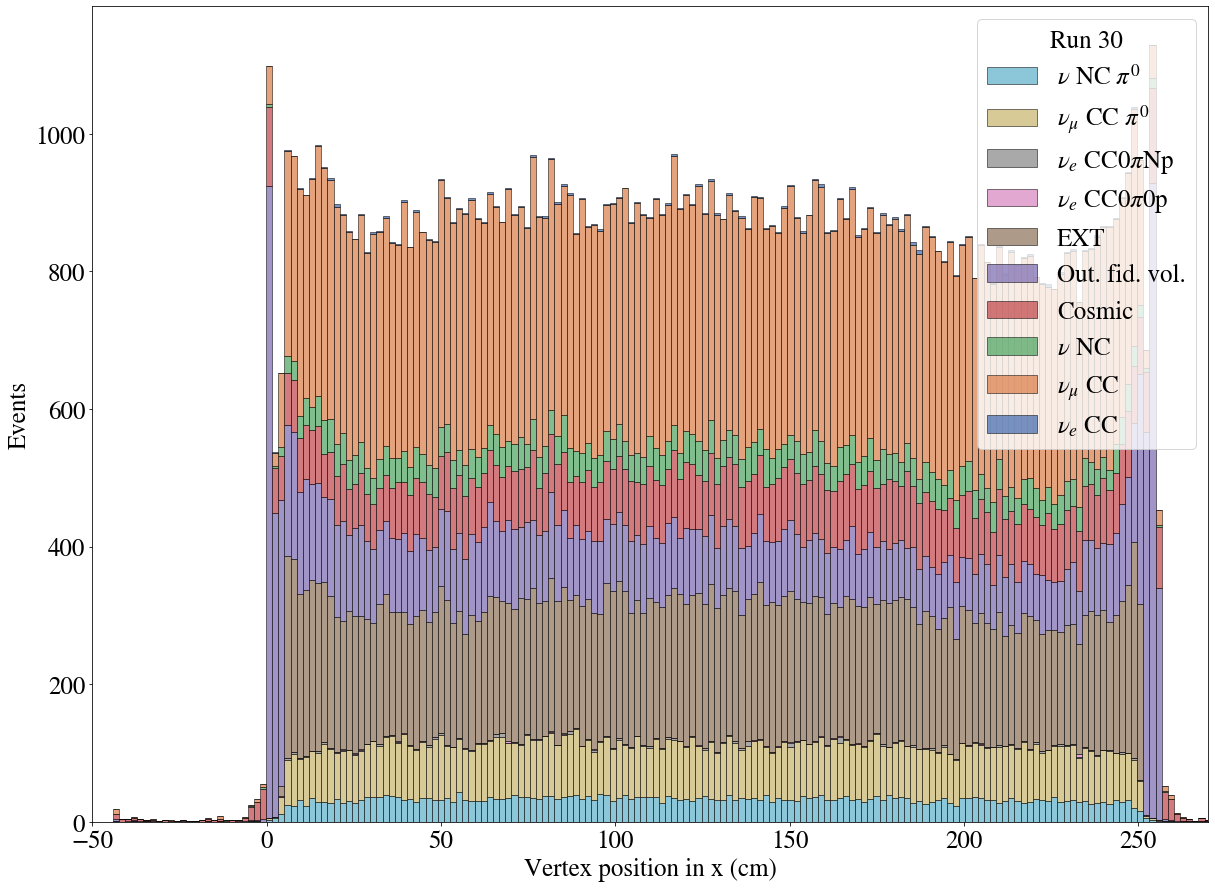

In [23]:
plt.figure(figsize=(20,15))
i = sns.histplot(data=MC_EXT, x="reco_nu_vtx_sce_x", hue="category", multiple="stack", palette = 'deep', weights = MC_EXT['weightSplineTimesTune']/(MC_EXT['scaling']), bins = 200, legend = False)
i.set(xlabel="Vertex position in x (cm)", ylabel = "Events")
plt.xlim([-50, 270])
plt.legend(title='Run 30', loc='upper right', labels=[r"$\nu$ NC $\pi^{0}$", r"$\nu_{\mu}$ CC $\pi^{0}$", r"$\nu_e$ CC0$\pi$Np", r"$\nu_e$ CC0$\pi$0p", r"EXT", r"Out. fid. vol.", r"Cosmic", r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC"])
plt.savefig('vertex_x1.jpg', dpi=300)
plt.show(i)